    Jacob Knopping
    1/13/2020

# 18.2 Assignment Prompt

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.

# 18.2 Assignment Code:

In [1]:
# import the relevant libraries:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
#load the data from the PostgreSQL database
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

#no need for an open connection (just the one query)
engine.dispose()

#view first 10 rows
houseprices_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [4]:
#Some columns are non-numerical
non_numeric_columns = houseprices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print('Non-numeric columns:', len(non_numeric_columns))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
Non-numeric columns: 43


In [5]:
numeric_columns = houseprices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("Numeric columns:", len(numeric_columns))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
Numeric columns: 38


Roughly half of the data is non-numeric.

In [6]:
#Missing data
total_missing = houseprices_df.isnull().sum()
total_count = houseprices_df.isnull().count()
percent_missing = 100*total_missing/total_count
print(percent_missing)

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
                   ...    
bedroomabvgr      0.000000
kitchenabvgr      0.000000
kitchenqual       0.000000
totrmsabvgrd      0.000000
functional        0.000000
fireplaces        0.000000
f

Many variables do not have missing values. Missing values will be filled if needed for a feature variable.

### Numeric EDA and Feature Selection

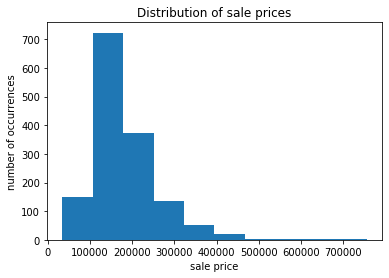

In [7]:
#Exploring distribution
plt.hist(houseprices_df.saleprice)
plt.title("Distribution of sale prices")
plt.xlabel("sale price")
plt.ylabel("number of occurrences")
plt.show()

Distribuiton is non-normal (skewed to the right).

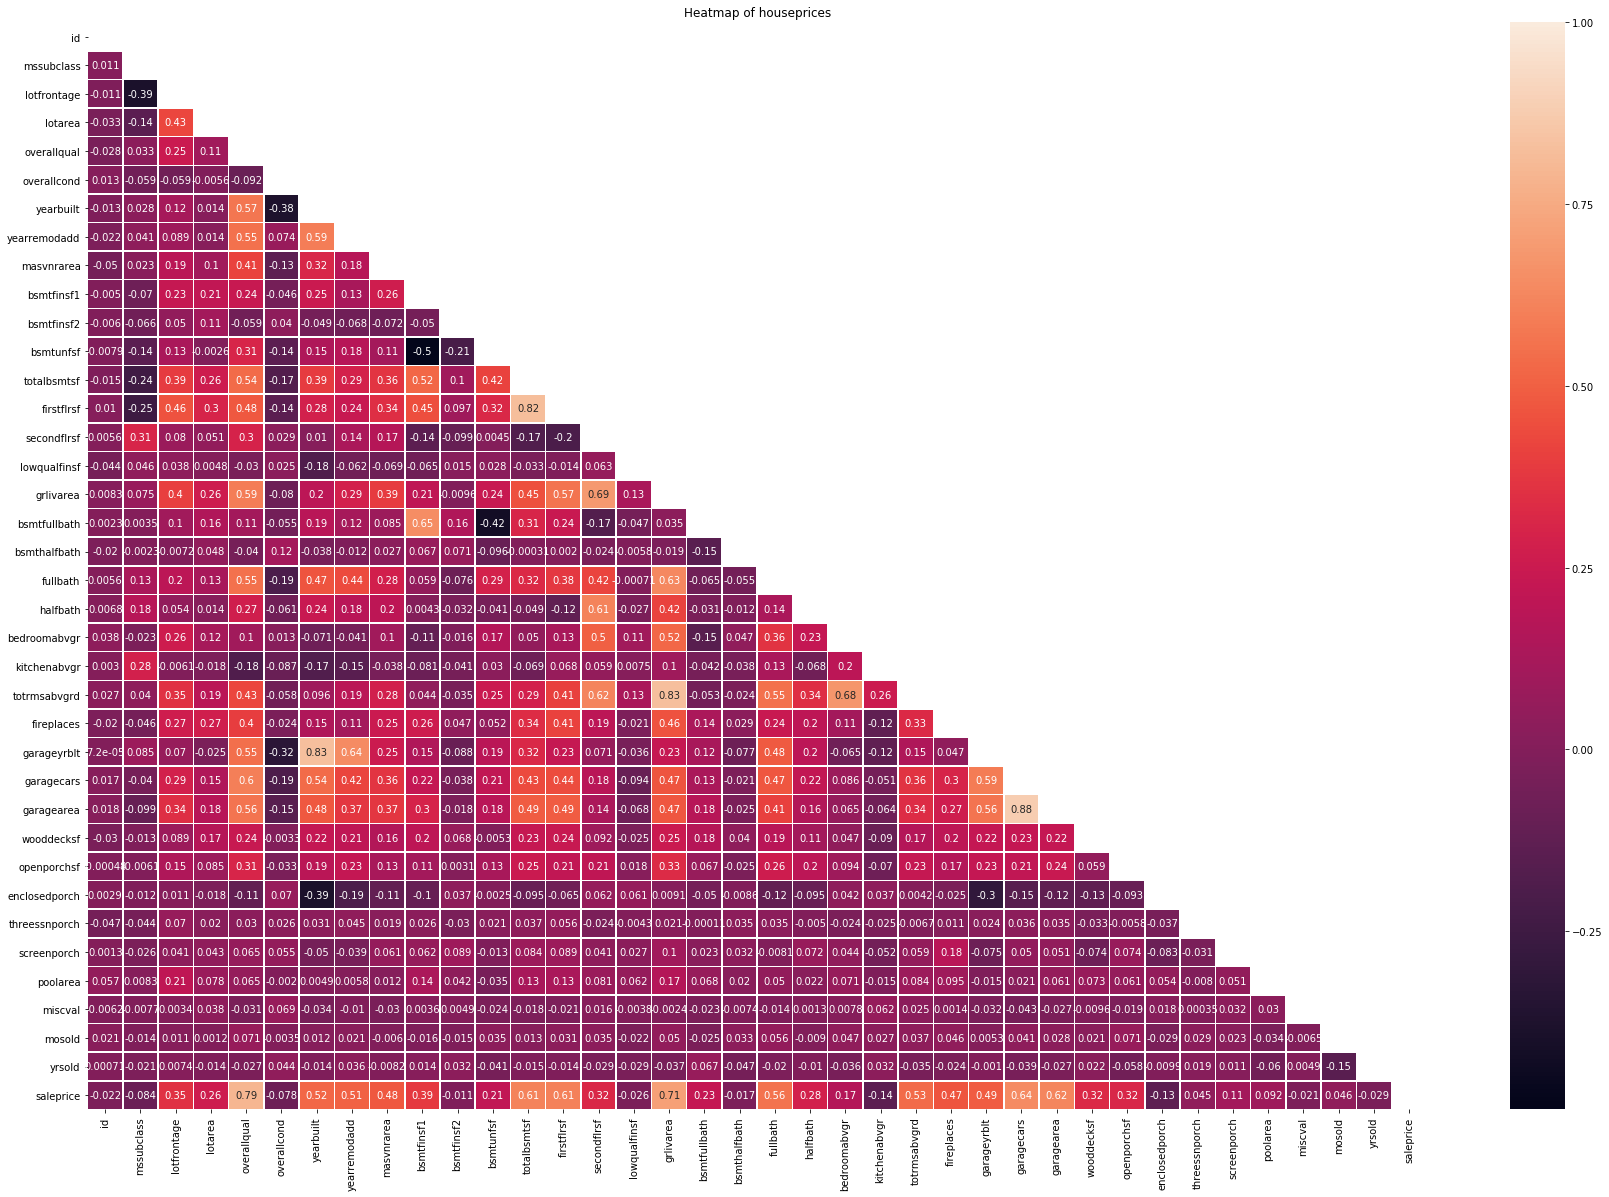

In [8]:
#Create a heatmap of all numeric data
corr = houseprices_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(30,20))
sns.heatmap(corr, mask=mask, annot=True, linewidths=.5)
plt.title('Heatmap of houseprices')
plt.show()

Based on the heatmap showing correlations, saleprices can be represented as a function of: 

    overallqual 
    grlivarea
    garagecars (only need one of these garage variabes as they are highly correlated with eachother)
    totalbsmtsf (totalbsmtsf and firstflrsf are correlated)
    yearbuilt (only use one of these year variables)
    
These are the variables with the strongest correlations (corr >= 0.6).

In [9]:
houseprices_df.overallqual.isnull().sum()

0

In [10]:
houseprices_df.grlivarea.isnull().sum()

0

In [11]:
houseprices_df.garagecars.isnull().sum()

0

In [12]:
houseprices_df.totalbsmtsf.isnull().sum()

0

In [13]:
houseprices_df.yearbuilt.isnull().sum()

0

None of these feature variables have missing values.

### Non-Numeric EDA and Feature Selection

In order to evaluate the target variable and non-numeric features, each feature is plotted against the targe variable:

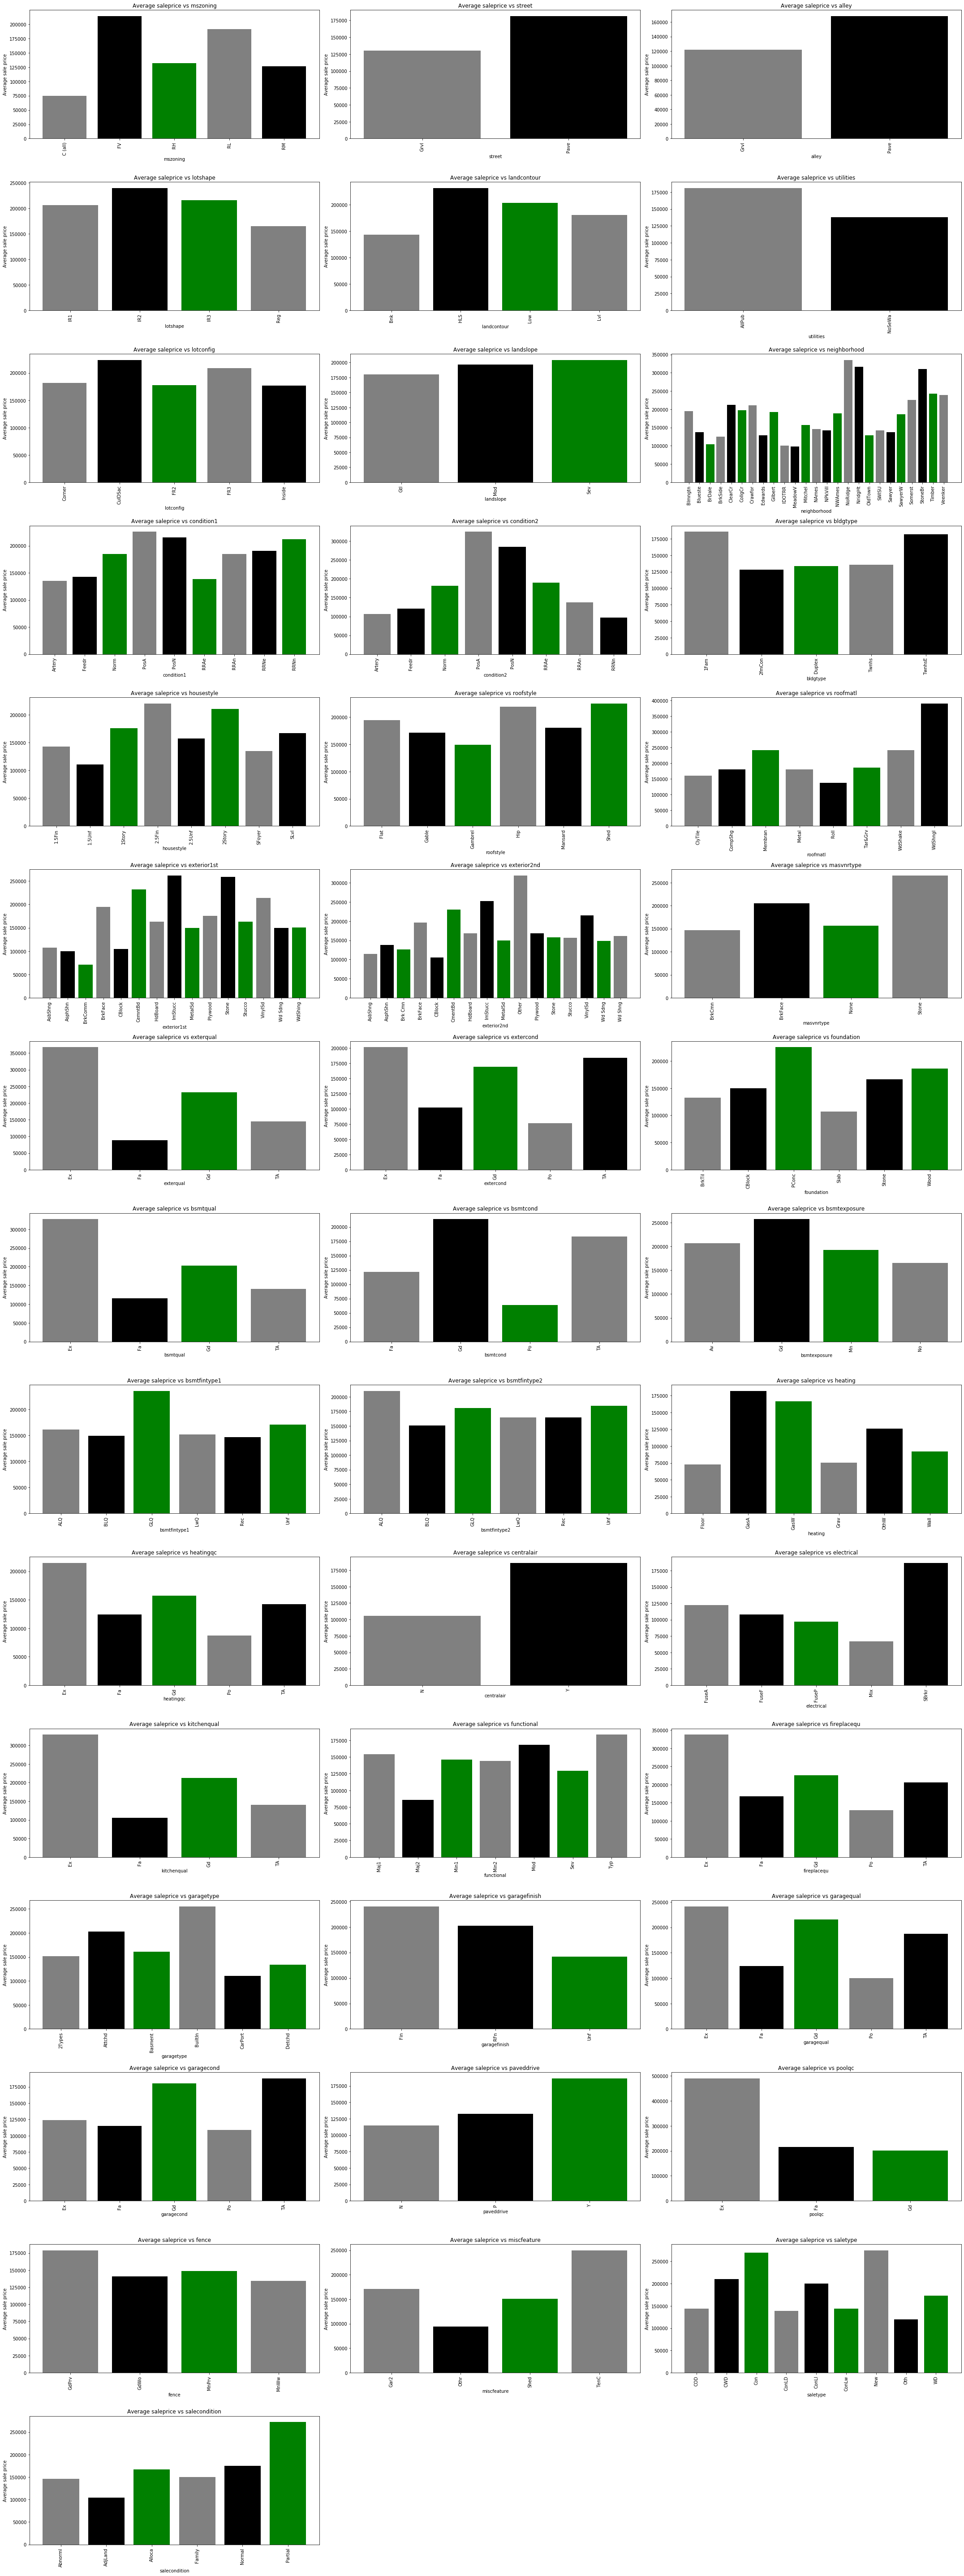

In [14]:
plt.figure(figsize=(30,80))

for index, column in enumerate(non_numeric_columns):
    #Remember we found there are 43 non-numeric columns/features
    plt.subplot(15,3,index+1)
    plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index,
            houseprices_df.groupby(column)['saleprice'].mean(), 
            color=('gray','black', 'green'))
    plt.title("Average saleprice vs {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Based on the barplots of non-numeric data, many more features have an impact on saleprice. Some of the features that stand out the most are mszoning, street, alley, utilities, neighborhood, exterqual, centralair, kitchenqual, and poolqc. All of these features will be incorporated in the model.


Based on numeric and non-numeric features, saleprices can be represented as a function of: 

    overallqual 
    grlivarea
    garagecars
    totalbsmtsf
    yearbuilt
    
    mszoning
    street
    alley
    utilities
    neighborhood
    exterqual
    centralair
    kitchenqual
    poolqc

In [15]:
#Selecting the features above
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.alley, prefix="alley", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.utilities, prefix="utilities", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.neighborhood, prefix="neighborhood", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.exterqual, prefix="exterqual", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.centralair, prefix="centralair", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.kitchenqual, prefix="kitchenqual", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.poolqc, prefix="poolqc", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.alley, prefix="alley", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.utilities, prefix="utilities", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.neighborhood, prefix="neighborhood", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.exterqual, prefix="exterqual", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.centralair, prefix="centralair", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.kitchenqual, prefix="kitchenqual", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.poolqc, prefix="poolqc", drop_first=True).columns)

## Regression Model

In [16]:
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'yearbuilt'] + dummy_column_names]
Y = houseprices_df.saleprice

import statsmodels.api as sm

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     160.4
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:36:41   Log-Likelihood:                -17223.
No. Observations:                1460   AIC:                         3.454e+04
Df Residuals:                    1414   BIC:                         3.478e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.703e+05   1.38e+05     -2.692      0.007    -6.4e+05      -1e+05
overallqual           1.181e+04   1192.966      9.902      0.000    9472.344    1.42e+04
grlivarea               46.7668      2.400     19.490      0.000      42.060      51.474
garagecars            1.155e+04   1643.258      7.031      0.000    8330.593    1.48e+04
totalbsmtsf             19.6626      2.662      7.387      0.000      14.441      24.884
yearbuilt              191.0568     68.164      2.803      0.005      57.343     324.771
mszoning_FV           3.119e+04   1.54e+04      2.027      0.043    1002.014    6.14e+04
mszoning_RH           2.612e+04   1.54e+04      1.698      0.090   -4052.087    5.63e+04
mszoning_RL           3.392e+04   1.28e+04      2.641      0.008    8723.878    5.91e+04
mszoning_RM           2.044e+04   1.22e+04      1.681      0.093   -3405.474    4.43e+04
street_Pave           3307.3682   1.47e+04      0.224      0.822   -2.56e+04    3.22e+04
alley_Pave           -1.177e+04   5962.440     -1.973      0.049   -2.35e+04     -70.625
utilities_NoSeWa     -4.762e+04   3.33e+04     -1.431      0.153   -1.13e+05    1.77e+04
neighborhood_Blueste  3507.4054    2.5e+04      0.140      0.889   -4.56e+04    5.26e+04
neighborhood_BrDale  -1828.6630   1.28e+04     -0.143      0.886   -2.69e+04    2.32e+04
neighborhood_BrkSide  2.193e+04   1.07e+04      2.057      0.040    1018.587    4.28e+04
neighborhood_ClearCr  3.525e+04   1.05e+04      3.346      0.001    1.46e+04    5.59e+04
neighborhood_CollgCr  1.774e+04   8423.348      2.106      0.035    1214.792    3.43e+04
neighborhood_Crawfor  4.045e+04   1.01e+04      4.014      0.000    2.07e+04    6.02e+04
neighborhood_Edwards  3730.9371   9406.283      0.397      0.692   -1.47e+04    2.22e+04
neighborhood_Gilbert  1.248e+04   8952.137      1.394      0.163   -5077.303       3e+04
neighborhood_IDOTRR   2.009e+04   1.23e+04      1.632      0.103   -4053.627    4.42e+04
neighborhood_MeadowV  9338.2003   1.28e+04      0.732      0.465   -1.57e+04    3.44e+04
neighborhood_Mitchel  1.319e+04   9628.126      1.370      0.171   -5700.680    3.21e+04
neighborhood_NAmes    9445.1701   8933.720      1.057      0.291   -8079.601     2.7e+04
neighborhood_NPkVill -4258.7698   1.38e+04     -0.309      0.758   -3.13e+04    2.28e+04
neighborhood_NWAmes   8093.9964   9265.975      0.874      0.383   -1.01e+04    2.63e+04
neighborhood_NoRidge  7.278e+04   9690.376      7.511      0.000    5.38e+04    9.18e+04
neighborhood_NridgHt  4.738e+04   9032.041      5.245      0.000    2.97e+04    6.51e+04
neighborhood_OldTown  8624.8895   1.09e+04      0.788      0.431   -1.28e+04    3.01e+04
neighborhood_SWISU    3909.2546   1.17e+04      0.335      0.738    -1.9e+04    2.68e+04
neighborhood_Sawyer   1.144e+04   9467.344      1.209    